In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Single-Level Breit-Wigner Resonace Demonstration
================================================

First define all of the needed parameters and constants, being careful with units.

In [2]:
A = 238                             # ratio of nuclear mass to neutron mass
a = (0.123*A**(1.0/3.0) + 0.08)*1e-12   # hard-sphere radius of nucleus, cm
I = 0                               # target spin, unitless
J = 0.5                             # compound nucleus spin, unitless
E_i = 6.67                          # location of resonance, eV
Gamma_i  = 0.02752                  # total resonance width, eV
Gamma_ni = 0.00152                  # neutron partial width, eV
Gamma_gi = 0.026                    # radiative capture partial width, eV
c = 2.99792458e10                   # speed of light in vacuum, cm/s
m = 939.57e6/c**2                   # mass of neutron, eV/c^2 = eV s^2/cm^2
hbar = 4.135667662e-15/(2.0*np.pi)  # reduced plank's constant, eV s
gJ = (2*J+1)/(2*(2*I+1))            # statistical spin factor, unitless

Cross Section Calculation
-------------------------

First, create a function to calculate the neutron wavelength as a function of energy.

In [3]:
def wavelength(E) : 
    return hbar/np.sqrt(2.0*E*A*m/(A+1)) # eV s/sqrt(eV eV s^2 / cm^2) = cm

Now create functions to calculate \sigma_0 and the potential cross section as functions of energy.

In [4]:
def sigma0(E) :
    return 4.0*np.pi*wavelength(E)**2*gJ*Gamma_ni/Gamma_i  # cm^2

In [5]:
def sigmap(E) :
    lmbda = wavelength(E)
    return 4.0*np.pi*lmbda**2*np.sin(a/lmbda)**2

Now we everything in place to calculate the the capture and elastic scattering cross sections.  Rather than doing the actual calculation here, I am going to create two functions that will do the calculation as a function of energy.

In [6]:
def sigma_g(E) :
    return sigma0(E)*Gamma_gi*Gamma_i/(Gamma_i**2 + 4.0*(E-E_i)**2)

In [7]:
def sigma_e(E) :
    phi0 = a/wavelength(E)
    return sigmap(E)**2 + sigma0(E)*(2/Gamma_i*(E-E_i)*np.sin(2.0*phi0) + Gamma_ni/Gamma_i - 2.0*np.sin(phi0)**2)*Gamma_i**2/(Gamma_i**2 + 4.0*(E-E_i)**2)

Calculate and plot:

21652.7932154


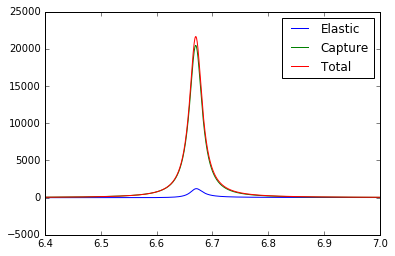

In [8]:
E = np.linspace(6.4,7.0,1000)
sigmae0 = sigma_e(E)*1.0e24  # elastic cross section, barns
sigmag0 = sigma_g(E)*1.0e24  # capture cross section, barns
sigmat0 = sigmag0+sigmae0      # total cross section, barns

elastic, = plt.plot(E,sigmae0)
capture, = plt.plot(E,sigmag0)
total,   = plt.plot(E,sigmat0)
plt.legend([elastic,capture,total],["Elastic","Capture","Total"])
print sigma0(E_i)*1e24

Doppler Broadening
------------------

Now let's calculate Doppler broadened cross sections.  We will do this using the psi-phi formulation.

In [25]:
def psi(u,beta) :
    (x,w) = np.polynomial.hermite.hermgauss(200)
    quadSum = 0.0
    for i in range(len(x)) :
        quadSum += 1.0/(1.0 + (x[i]*beta+u)**2)*w[i]
    return 1.0/(np.sqrt(np.pi))*quadSum

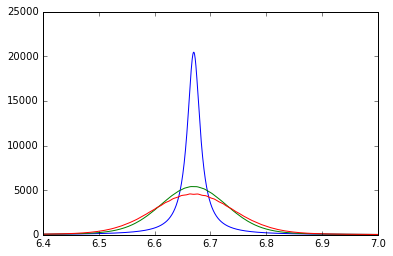

In [28]:
k = 8.61734e-5 # eV/K
E = np.linspace(6.4,7.0,1000)
u = 2.0/Gamma_i*(E-E_i)

sigmag0 = sigma_g(E)*1.0e24  # capture cross section, barns

T = 600
Delta = 2.0*np.sqrt(E_i*k*T/A)
beta = 2.0*Delta/Gamma_i
sigmag600 = sigma0(E)*Gamma_gi/Gamma_i*psi(u,beta)*1.0e24  # capture cross section, barns

T = 900
Delta = 2.0*np.sqrt(E_i*k*T/A)
beta = 2.0*Delta/Gamma_i
sigmag900 = sigma0(E)*Gamma_gi/Gamma_i*psi(u,beta)*1.0e24  # capture cross section, barns


captuer0, = plt.plot(E,sigmag0)
capture600, = plt.plot(E,sigmag600)
capture900, = plt.plot(E,sigmag900)

Resonance Absorption
--------------------

Let's look at this resonances effect on the flux spectrum.  For neutrons to be slowing down past the resonance, we need a moderating material.  Let's use hydrogen and calculate its potential cross section using the hard-sphere formula for nuclear radius.  I will also define the ratio of moderator number density to absorber density as 115.

In [337]:
sigmaSM = 4.0*np.pi*(0.123 + 0.08)**2   # b
NMtoNR = 115.0

Now use the narrow and wide resonance approximations to estimate the the spectrum in and around the resonance.

In [340]:
E = np.linspace(6.0,7.0,1000)
sigmaSRes = sigma_e(E)*1.0e24    # elastic cross section, barns
sigmaARes = sigma_g(E)*1.0e24    # capture cross section, barns
sigmaTRes = sigmaARes+sigmaSRes  # total cross section, barns

phi_NR = (NMtoNR*sigmaSM + sigmap(E))/((sigmaTRes + NMtoNR*sigmaSM)*E)
phi_WR = NMtoNR*sigmaSM/((sigmaARes + NMtoNR*sigmaSM)*E)

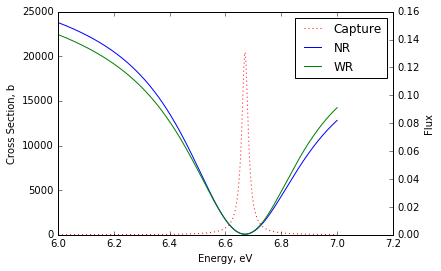

In [341]:
fig, ax1 = plt.subplots()
capture, = ax1.plot(E,sigmaARes,":r")
ax1.set_xlabel("Energy, eV")
ax1.set_ylabel("Cross Section, b")

ax2 = ax1.twinx()
nrSpec,wrSpec = ax2.plot(E,phi_NR, E,phi_WR)
ax2.set_ylabel('Flux')

plt.legend([capture,nrSpec,wrSpec],["Capture","NR","WR"])